In [1]:
from source.MI import MI
from source.datalib import *
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import torch
from torch import nn
from torch.functional import F
import torch.optim.lr_scheduler as lr_scheduler

wavelength_to_index = lambda x, wavelengths: np.argmin( np.abs( wavelengths - x ) )

# Algorithm

In [46]:
class AffineTransform(nn.Module):
    def __init__(self, scale=1., transX=0., transY=0., angle=0., device='cpu'):
        super().__init__()
        self.scale = nn.Parameter(torch.tensor(scale, dtype = torch.float, device = device))
        self.transX = nn.Parameter(torch.tensor(transX, dtype = torch.float, device = device))
        self.transY = nn.Parameter(torch.tensor(transY, dtype = torch.float, device = device))
        self.angle = nn.Parameter(torch.tensor(angle, dtype = torch.float, device = device))
        self.device = device

    def get_theta(self):
        cos_angle = torch.cos(self.angle)
        sin_angle = torch.sin(self.angle)
        return torch.stack([
            torch.cat([(self.scale * cos_angle).unsqueeze(0), (-self.scale * sin_angle).unsqueeze(0), self.transX.unsqueeze(0)]),
            torch.cat([(self.scale * sin_angle).unsqueeze(0), (self.scale * cos_angle).unsqueeze(0), self.transY.unsqueeze(0)])
        ]).unsqueeze(0)

    def forward(self, x):
        theta = self.get_theta()
        grid = F.affine_grid(theta, x.size(), align_corners = False)
        return F.grid_sample(x, grid, align_corners = False)

def optimize_affine_transform_pytorch(to_transform, target_image, rot_angle_range, device = 'cpu', lr = 1e-2):
    mutual_info = MI(dimension = 2, num_bins = 64, kernel_sigma = 1).to(device)

    best_params = None
    best_loss = float('inf')

    # Convert images to torch tensors and move to specified device
    to_transform = torch.tensor(to_transform).unsqueeze(0).unsqueeze(0).float().to(device)
    target_image = torch.tensor(target_image).unsqueeze(0).unsqueeze(0).float().to(device)

    for rot_angle in rot_angle_range:
        # Initialize the affine transform module
        model = AffineTransform(scale = 1.0, transX = 0.0, transY = 0.0, angle = rot_angle, device = device)
        optimizer = torch.optim.SGD(model.parameters(), lr = lr)
        # scheduler = lr_scheduler.LinearLR(optimizer, start_factor = 1, end_factor = 1e-2, total_iters = 80)

        for epoch in range(100):
            optimizer.zero_grad()
            transformed_image = model(to_transform)
            loss = -mutual_info.mi(transformed_image, target_image)
            loss.backward()
            optimizer.step()
            # scheduler.step()
            
            print(f'Epoch: {epoch}, loss: {loss.item():.3f}', end='\r')
            if loss.item() < best_loss:
                best_loss = loss.item()
                best_params = {
                    'rot_angle': model.angle.item(),
                    'translate': [model.transX.item(), model.transY.item()],
                    'scale': model.scale.item()
                }

    return best_params, model

# 1. Testing

To test the capabilities of this algorithm we will test two different image alingnment scenarios, (i) libs dataset will be aligned with an optical image: since both images display the entire sample, it should work relatively easily; (ii) libs dataset will be alinged with one from ICP-MS: this is particularly challenging due to the fact that the libs dataset captures the enirety of the sample, while the ICP-MS correponds to a particular sample region.

## 1.1 LIBS and Optical Image

### 1.1.1 LIBS

In [3]:
file_libs_metadata = r'E:/Data/Data_LIBS/Data_Brno/P36 - Epithelioid angiosarcoma/LIBS/Kopie souboru 403x540-P36B-Avantes.libsmetadata.txt'
file_libs_data = r"E:/Data/Data_LIBS/Data_Brno/P36 - Epithelioid angiosarcoma/LIBS/Kopie souboru 403x540-P36B-Avantes.libsdata"

libs_manipulator = MapData(file_path = file_libs_data)
libs_manipulator.load_wavelenths()
libs_manipulator.load_all_data('libs')
libs_manipulator.baseline_correct()

libs_manipulator.get_map_dimensions()
nx, ny = libs_manipulator.map_dimensions
spectrum = libs_manipulator.spectra.reshape(ny, nx, -1)
wavelengths = libs_manipulator.wvl

# Correct flipped dimensions
spectrum[1::2, :] = spectrum[1::2, ::-1]

loading wavelengths
loading metadata
preprocessed file was not found; setting overwrite to True
loading raw data
getting baselines
getting map dimensions


In [4]:
modality1 = spectrum[::-1, :, wavelength_to_index(266.106, wavelengths)].T

### 1.1.2 Optical Image

In [7]:
main_dir = r"E:/Data/Data_LIBS/Data_Brno/"
sample_dir = r"P36 - Epithelioid angiosarcoma//"
dir_image = main_dir + sample_dir + r"Histology//"

def read_image(folder, index = 0):
    files = [folder + '//' + f for f in os.listdir(folder) if f.endswith('jpg')]
    return io.imread(files[index])

sample_image = read_image(dir_image)

In [16]:
modality2 = sample_image[:, 250:1450, 0][::2, ::2]

## 1.2 Set same grid size

This will be achieved using standard padding

In [17]:
x_pad = modality2.shape[0] - modality1.shape[0]
y_pad = modality2.shape[1] - modality1.shape[1]

modality1_corrected_grid = np.pad(modality1, pad_width = ((0, x_pad), (0, y_pad)))

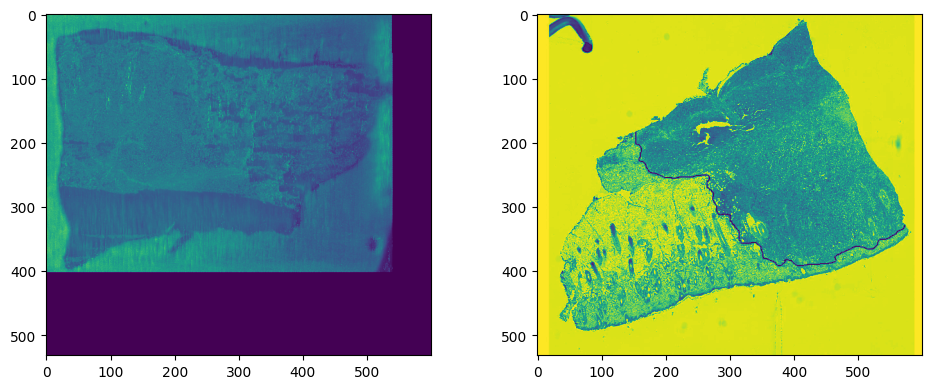

In [40]:
fig, axs = plt.subplots(1, 2, figsize = (10, 4))

ax = axs[0]
ax.imshow(modality1_corrected_grid)

ax = axs[1]
ax.imshow(modality2)

fig.tight_layout()

## 1.3 Align

In [49]:
device = 'cpu' #'cuda' if torch.cuda.is_available() else 'cpu'
rot_angle_range = np.linspace(0, 3*np.pi/2, 4)
best_params, mode = optimize_affine_transform_pytorch(modality1_corrected_grid, modality2, rot_angle_range, device = device, lr = 0.1)
print(best_params)

{'rot_angle': 3.5572192668914795, 'translate': [-0.004400716628879309, -0.18427670001983643], 'scale': 1.332689642906189}


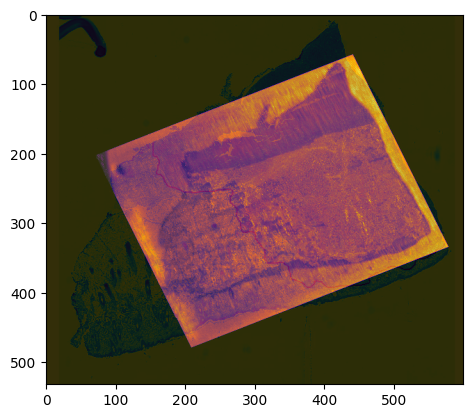

In [56]:
scale = best_params['scale']
angle = best_params['rot_angle']
tx = best_params['translate'][0]
ty = best_params['translate'][1]

affine_final = AffineTransform(scale, tx, ty, angle)
transformed_image = affine_final(torch.tensor(modality1_corrected_grid).float().unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0).detach().numpy()

plt.figure()
plt.imshow(modality2)
plt.imshow(transformed_image, cmap = 'inferno', alpha = 0.8)